In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

def read_aws(stn_id, times, state):
    if state in ["tas","nt"]: 
        dtypes = {"hd":str, "stn_id":str, "yyyy_lt":str,"mm_lt":str,"dd_lt":str,"hh_lt":str,"MM_lt":str,\
                "utc_yyyy":str,"utc_mm":str,"utc_dd":str,"utc_hh":str,"utc_MM":str,"gust":str, "q":str, "#":str}
        df=pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+state+"_one_min_gust/HD01D_Data_*"+stn_id+"*.txt")[0],\
            names=list(dtypes.keys()),header=0,dtype=dtypes)
        df["dt_utc"] = pd.to_datetime(df["utc_yyyy"] + df["utc_mm"] + df["utc_dd"] + df["utc_hh"] + df["utc_MM"], format="%Y%m%d%H%M")
        df["dt_lt"] = (df["yyyy_lt"] + df["mm_lt"] + df["dd_lt"] + df["hh_lt"] + df["MM_lt"])
        df = df.set_index("dt_utc")
        df["gust"] = pd.to_numeric(df["gust"], errors="coerce") / 3.6
        df = df[["hd","stn_id","dt_lt","gust","q","#"]]
    else:
        dtypes = {"hd":str, "stn_id":str, "dt_lt":str, "dt_utc":str, "gust":str, "q":str, "#":str}
        df=pd.read_csv(glob.glob("/g/data/eg3/ab4502/ExtremeWind/obs/aws/"+state+"_one_min_gust/HD01D_Data_*"+stn_id+"*.txt")[0],\
            names=["hd","stn_id","dt_lt","dt_utc","gust","q","#"],header=0,dtype=dtypes)
        df["dt_utc"] = pd.to_datetime(df["dt_utc"], format="%Y%m%d%H%M")
        df = df.set_index("dt_utc")
        df["gust"] = pd.to_numeric(df["gust"], errors="coerce")    
    return df.loc[slice(times[0], times[1])]

def resample(x,y,f,N):
    
    x_resamp = [np.percentile(x[np.random.randint(0,len(x),len(x))],f) for N in np.arange(N)]
    y_resamp = [np.percentile(y[np.random.randint(0,len(y),len(y))],f) for N in np.arange(N)]
    
    return [ [np.percentile(np.stack(x_resamp),2.5,axis=0), np.percentile(np.stack(x_resamp),97.5,axis=0)],
            [np.percentile(np.stack(y_resamp),2.5,axis=0), np.percentile(np.stack(y_resamp),97.5,axis=0)]]

This notebook is intended to test the following: What is the impact of using 10-minute instantaneous gusts from 5-minute BARPA-R data, rather than using a 10-minute maximum from 5-minute data? We can test this by using one-minute observations.

In [40]:
#Load one year of one-minute obs at Melb Airport
df = read_aws("86282",["2005-1-1","2015-12-31 23:59"],"vic")

In [41]:
#Resample to every 5 minutes
gust_5min = df[["gust"]].resample("5min").first()

In [42]:
#Now compare a 10-min max with 10-min inst
gust_10min_max = gust_5min.resample("10min").max()
gust_10min_inst = gust_5min.resample("10min").first()

In [48]:
#Just for summer months
gust_10min_max = gust_10min_max.iloc[np.in1d(gust_10min_max.index.month,[12,1,2])][["gust"]].dropna()
gust_10min_inst = gust_10min_inst.iloc[np.in1d(gust_10min_inst.index.month,[12,1,2])][["gust"]].dropna()

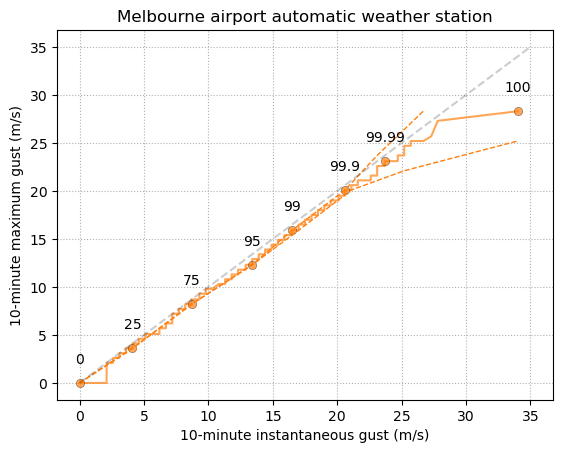

In [61]:
quant_labels = [0,25,75,95,99,99.9,99.99,100]
N = 1000
p = 1000; p2 = int(values_max.shape[0] * 0.05)
quants = np.array(list(np.linspace(0,95,p)) + list(np.linspace(95,100,p2)))
values_max = gust_10min_max.gust.values
values_inst = gust_10min_inst.gust.values

plt.plot(np.percentile(values_max,quants),np.percentile(gust_10min_inst,quants),ls="-",marker="none",mec="k",mew=0.3,alpha=0.7,color="tab:orange")
plt.plot(np.percentile(values_max,quant_labels),np.percentile(gust_10min_inst,quant_labels),ls="none",marker="o",mec="k",mew=0.3,alpha=0.7,color="tab:orange")
[plt.text(np.percentile(values_max,q),np.percentile(gust_10min_inst,q)+2,str(q),ha="center") for q in quant_labels]
obs_resamp, mod_resamp = resample(values_max, values_inst, quant_labels, N)
plt.plot(obs_resamp[0],mod_resamp[1], color="tab:orange",alpha=1, ls="--", lw=1)
plt.plot(obs_resamp[1],mod_resamp[0], color="tab:orange",alpha=1, ls="--", lw=1)
plt.plot([0,35],[0,35],color="k",ls="--",alpha=0.2)
plt.gca().grid(ls=":")
plt.title("Melbourne airport automatic weather station")
plt.xlabel("10-minute instantaneous gust (m/s)")
plt.ylabel("10-minute maximum gust (m/s)")

plt.savefig("/g/data/eg3/ab4502/figs/barpa/inst_vs_max.jpeg",dpi=400,bbox_inches="tight")

In [60]:
max_quants = gust_10min_max.quantile(np.array([0,25,75,95,99,99.9,99.99,100])/100.)
inst_quants = gust_10min_inst.quantile(np.array([0,25,75,95,99,99.9,99.99,100])/100.)
quants = pd.concat([max_quants.rename(columns={"gust":"10-minute maximum"}),inst_quants.rename(columns={"gust":"10-minute instantaneous"})],axis=1)
quants["bias"] = (quants["10-minute instantaneous"] - quants["10-minute maximum"])# / quants["10-minute maximum"] * 100
#print(quants["bias"].mean())
quants

,10-minute maximum,10-minute instantaneous,bias
0.0000,0.0,0.0,0.0
0.2500,4.1,3.6,-0.5
0.7500,8.7,8.2,-0.5
0.9500,13.4,12.3,-1.1
0.9900,16.5,15.9,-0.6
0.9990,20.6,20.1,-0.5
0.9999,23.7,23.1,-0.6
1.0000,34.0,28.3,-5.7
